In [1]:
from keras.datasets import boston_housing

# boston_housing includes information of housings at Boston during the 1970's dependant on factors such as crime rate
# prices vary from $10000 to $50000, the units are 1 = $1000
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# normalize data
mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

from keras import models
from keras import layers

# function which creates neural network
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1], )))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    # rmsprop is a modified version of gradient descent, mse is mean square error, and mae is mean absolute error
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    
    return model

Using TensorFlow backend.


In [18]:
import numpy as np
from IPython.display import clear_output

# K-fold cross-validation (used when validating with little available data)
k = 4
num_val_samples = len(train_data) // k
num_epochs = 150
mae_history = []

for i in range(k):
    print(f'Processing fold #{i+1}')
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[: i * num_val_samples], train_data[(i+1) * num_val_samples :]])
    partial_train_targets = np.concatenate([train_targets[: i * num_val_samples], train_targets[(i+1) * num_val_samples :]])
    
    model = build_model()
    
    history = model.fit(partial_train_data,
                        partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs = num_epochs,
                        batch_size = 1,
                        verbose = 0) # verbose doesn't display the process of the neureal network onto the output
    
    
    mae_history.append(history.history['val_mean_absolute_error'])

# takes average of all four partitions (k = 4)
average_mae_history = [np.mean([x[i] for x in mae_history]) for i in range(num_epochs)]

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


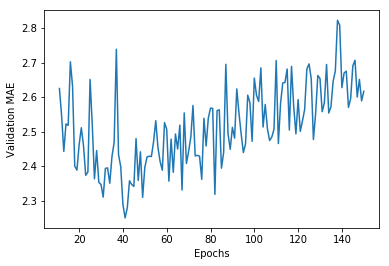

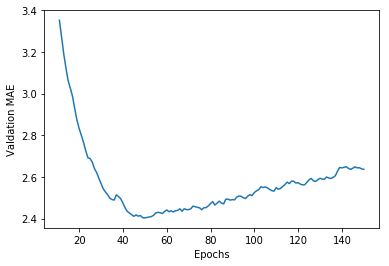

In [27]:
import matplotlib.pyplot as plt

# omits the first 10 points because they are very high error values
plt.plot(range(11, len(average_mae_history)+1), average_mae_history[10:])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# smoothen points using the exponential moving average of the current and previous point
def smooth_curve(points, factor = 0.9):
    smooth_points = []
    for point in points:
        if smooth_points:
            previous = smooth_points[-1]
            smooth_points.append(previous*factor + point*(1-factor))
        else: # it's the first point
            smooth_points.append(point)
            
    return smooth_points

smooth_mae_history = smooth_curve(average_mae_history)
plt.clf()
plt.plot(range(11, len(smooth_mae_history)+1), smooth_mae_history[10:])
plt.xlabel('Epochs')
plt.ylabel('Valdation MAE')
plt.show()

In [26]:
# analyzing the previous graphs, it becomes evident that the optimal epochs is around 50
model = build_model()

model.fit(train_data,
          train_targets,
          epochs = 50,
          batch_size = 16,
          verbose = 0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print("Test MSE Score:", test_mse_score)
print("Test MAE Score:", test_mae_score)

102/102 [==============================] - 0s 3ms/step
Test MSE Score: 17.21833891027114
Test MAE Score: 2.6908134011661304
